# Deep Learning Assignment 3

This notebook explores image captioning using three models: VGG19, EfficientNet v2 S and Inception ResNet v2. Each model is used to extract featurs from the Flickr8k images which comprise of 6000 training ,1000 validation and 1000 test images respecively. Each image has 5 human made captions associated with it describing the image.

To process the uman made captions for the dataset, we tokenise them giving each word a unique number. We then run the tokenized results through either a Long Short Term Memory architecture (LSTM) or a Gated Recurrent Unit (GRU). Each handle text in a different way.

Finally the output features form the vision model is combined with the output of the LSTM/GRU model and merged into a final output for further predictions.

A large issue that came up in this notebook was that the models stopped working when aplying a validation set. Various attemtpts such as loading the whole or a subset of validation set into memory failed. Using a datagenerator on the validation also failed. Both methods seemed to pause the notebook for hours at a time with no obvious training occuring. Without the validation data, the training occured as expected. This issue should be looked into as using a validation set is incredibly useful to avoid overfitting and greatly aids model seletion.

Although many attempts were made such as fitting bulk validation to memeory and creating generators, it proved imporssible to use the validation dataset when training the model
As such to improve training, the validation and training were combined into one large training file of the 6000+1000- images respectively for training and validation.

The training and validation sets were combined into one set as not to loose the extra 1000 images which may improve the model. It seemed wsateful to not use them at all since no validation was being performed

### Import libraries

In [125]:
# Standard libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import string
from tqdm.notebook import tqdm
from datetime import datetime
from collections import Counter

import numpy as np
from numpy import array, argmax

import pandas as pd
pd.options.mode.chained_assignment = None 

# pickle imports for saving thigns that are too large for memory
import pickle
from pickle import load
from pickle import dump

# Tensorflow improts for model building 
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small 
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.efficientnet_v2  import EfficientNetV2S, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, GRU,Attention

# import BLEU metric
from nltk.translate.bleu_score import corpus_bleu

### Define file paths

As l'm working on my local machine, I'm setting my path to where my files are stored

In [2]:
# root directory
filepath = "C:/Users/Declan/Desktop/MDSI/2022/DL - 94691/Assignment 3/"

# path to image and text files
image_filepath = filepath + 'Flickr8k_Dataset/Flicker8k_Dataset/'
text_filepath = filepath + 'Flickr8k_text/'

### Get train, validation and test images

Use root directory from above to path into where the images and the text information is located

In [3]:
# text images and image filepath
image_filepath = filepath + 'Flickr8k_Dataset/Flicker8k_Dataset/'
text_filepath = filepath + 'Flickr8k_text/'

Each of the below text files displays the image id e.g. 667626_18933d713e.jpg of the corresponding set

In [4]:
# Set path for train, validation and test text files
train_filename = filepath+'Flickr8k_text/Flickr_8k.trainImages.txt'
val_filename = filepath+'Flickr8k_text/Flickr_8k.devImages.txt'
test_filename = filepath + 'Flickr8k_text/Flickr_8k.testImages.txt'

### Concat the train and validation images

As mentioned earlier, the issues of using a validation set led to an alternative of combining the train and validation sets toghether into what is reffered to as the combined trainin val set

In [5]:
# combine both the training and the validation

# Reads all lines in training txt
file1 = open(train_filename,'r')
file1_contents = file1.read()
file1.close()
# Reads all lines in validation txt
file2 = open(val_filename,'r')
file2_contents = file2.read()
file2.close()

# Concatentate the lists of files 
combined_training_val = file1_contents+file2_contents

### Write concatenated list to file called combined train val

In [6]:
# write the combined list to a new txt file

with open(filepath + 'Flickr8k_text/combined_train_val.txt', 'w') as f:
    f.write(combined_training_val)
    
combined_filename = filepath + 'Flickr8k_text/combined_train_val.txt'

## Process images

The image processing process is where we inut the images into the vision models. The last layers of the models have een removed as we don't want a prediction we want the features expressed as a numpy array. This is then combined with the text processing for final model output.

In [150]:
# Function to extract features from images
# Inputs are the filename e.g. test, combined text files and which model we want to use
# The process is the same for each so we can just add the extra selectin to the input
# all models use the imagenet weights

def extract_features(file, model):#directory
    # load the model
    if model == 'vgg19':
        model = VGG19(weights='imagenet')
        target_size = (224, 224)
        
    elif model == 'efficientnetv2s':
        model = EfficientNetV2S(weights='imagenet')
        target_size = (384, 384)
    
    elif model == 'inception_resnet_v2':
        model = InceptionResNetV2(weights='imagenet')
        target_size = (299, 299)
        
    elif model == 'mobilenetv3s':
        model = MobileNetV3Small(weights='imagenet')
        target_size = (576, 576)    
        
    # re-structure the model - remove predicting layers we don't want
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # create empty dictionary - output will be {file1: [array of feaures], file2:[array of feaures]}
    features = dict()
    
    # open files
    opened_file = open(file,'r')
    
    # read contents
    opened_file_contents = opened_file.read()
    
    # split by line seperator
    opened_file_contents = list(opened_file_contents.split('\n'))
        
    # loop over all images using their name
    for image_name in opened_file_contents:
        
        # check that filename seems legitimate 
        if len (image_name) <10:
            pass
        else:
            # if image is legit
                
            # set path to image    
            image_path = image_filepath +  image_name
            
            # load image using path - target size is dependent on models specified above
            image = load_img(image_path, target_size = target_size)

            # convert the image pixels to a numpy array
            image = img_to_array(image)
            
            # reshape data for the model
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            
            # prepare the image for the vision model
            image = preprocess_input(image)
            
            # get features by running image through vision model
            feature = model.predict(image, verbose=0)
            
            # get image id - remove .jpg from end abc.jpg splits to abc .jpg, select first element abc
            image_id = image_name.split('.')[0]
            
            # store feature
            features[image_id] = feature
            
    # return dictionary of image name features
    return features

## Text processing

We need to perform some text processing to clean the text data. The first step is to convert all words to lower case. Then we need to remve punctuation and numbers. Once punctionation is removed we may have some isolated s's e.g. (it's -> it s). We can also remove isolated a's (e.g. a child walks throught the whatever -> child walks throught the whatever)

The model can't work with words so in stead each word in encoded to a number e.g. the  = 1, ball = 2 etc for all words in the combined dataset.

The dataset comes with token .txt with all original captions and a lemmatized verions wher the captions are down to their base word (e.g.a man jumped -> a man jump whre jump is the root of jumped)



In [8]:
# Function to load a given file into memory then close it, the contents of the file are returned
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

### Load text data

In [9]:
filename_token = filepath+'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename_token)

In [10]:
# function to process the textand provide mapping

# extract descriptions for images
def load_descriptions(doc):
    
    # create empty dict
    mapping = dict()
    
    # split lines by line seperator
    for line in doc.split('\n'):
        
        # split line by white space each split is a word
        tokens = line.split()
        
        # skip line if too short
        if len(line) < 2: 
            continue
            
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        
        # remove filename from image id abc.jpg split to abc and .jpg, grab first item
        image_id = image_id.split('.')[0]
        
        # convert description tokens back to string 
        image_desc = ' '.join(image_desc)
        
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
            
        # store description
        mapping[image_id].append(image_desc)
    return mapping

In [11]:
# parse descriptions and show length 
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


### Clean descriptions

In [12]:
# remove punctuation

def clean_descriptions(descriptions):
    
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    
    for key, desc_list in descriptions.items():
        
        for i in range(len(desc_list)):
            # get item in list
            desc = desc_list[i]
            
            # tokenize the item
            desc = desc.split()
            
            # convert to lower case
            desc = [word.lower() for word in desc]
            
            # remove punctuation from each token using translate
            desc = [w.translate(table) for w in desc]
            
            # remove hanging 's' and 'a' or some other short word which may pop up. Filter by longer than 1
            desc = [word for word in desc if len(word)>1]
            
            # remove tokens with numbers in them using is alpha
            desc = [word for word in desc if word.isalpha()]
            
            # store as string
            desc_list[i] =  ' '.join(desc)



### Get cleaned descriptions

In [13]:
# get clean descriptions
clean_descriptions(descriptions)

In [14]:
# function to get all words in descriptions


def to_vocabulary(descriptions):
    
    # build a list of all description strings , set only returns unique entries (a,b,a) -> (a,b)
    all_desc = set()
    
    # iterate over caption
    for key in descriptions.keys():
        
        # split caption up and add to set above
        [all_desc.update(d.split()) for d in descriptions[key]]
        
    # return unique vocab    
    return all_desc

### Get unqiue vocab words

In [15]:
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


## Set up the deep learning loading of model

In [16]:
# load a pre-defined list of photo identifiers

def load_set(filename):
    # load in a filename with images of interest
    doc = load_doc(filename)
    
    # create empty list to append to 
    dataset = list()
    
    # iterate over split lines, each line is a different file name
    for line in doc.split('\n'):
        
        # skip empty lines
        if len(line) < 1:
            continue
            
        # get the image identifier dont carea bouat .jgg
        identifier = line.split('.')[0]
        
        # appedn to earlier list
        dataset.append(identifier)
        
    # return list of image names    
    return set(dataset)

In [17]:
# function to load clean descriptions

def load_clean_descriptions(filename, dataset):
    
    # load document
    doc = load_doc(filename)
    
    # create emtpty dict
    descriptions = dict()
    
    # iterate over split lines
    for line in doc.split('\n'):
        
        # split line by white space
        tokens = line.split()
        
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        
        # skip images not in the set
        if image_id in dataset:
            
            # add image if not in dict
            if image_id not in descriptions:
                descriptions[image_id] = list()
                
            # wrap description in tokens 
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            
            # store
            descriptions[image_id].append(desc)
            
    # return descriptions as dict { file1 : [caption1, caption2....], file2 : [capton1 ...]}        
    return descriptions

### Load in relevant datasets

In [18]:
test = load_set(test_filename)
combined = load_set(combined_filename)

test_descriptions = load_clean_descriptions(filepath+'descriptions.txt', test)
combined_descriptions = load_clean_descriptions(filepath+'descriptions.txt', combined)

In [19]:
# convert a dictionary of clean descriptions to a list of descriptions

def to_lines(descriptions): 
    # create empty list
    all_desc = list()
    
    # iterate over all keys
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    
    # use function to get each line of dict
    lines = to_lines(descriptions)
    
    # apply tokenizer to line
    tokenizer = Tokenizer()
    
    # fit using tf function
    tokenizer.fit_on_texts(lines)
    
    return tokenizer

## Tokenize words
Need to add 1 to vocab to account for startseq

In [20]:
# Using combined train+validation to et list of unique vocab
tokenizer = create_tokenizer(combined_descriptions)

# add 1  becuase we added startseq to descriptions
vocab_size = len(tokenizer.word_index) + 1

In [21]:
# find maximum number of words in the whole combined set

def max_length(description):

    #set base of 0
    length_max_caption_words = 0

    # iterate over filename in dict
    for image in list(description.keys()):
        
        #iterate over captions for each filename
        for caption in description[image]:
            
            # split by white space
            cap_split = caption.split(' ')

            # count number of white space. words = number of white spaces +1 (e.g. A dog has 1 white space for two words)
            if len(cap_split) > length_max_caption_words:
                
                # if length is larger than current length, update 
                length_max_caption_words = len(cap_split)
                
    # return the maximum lengt of any caption            
    return length_max_caption_words            

## Defining models

l'm using three models in this notebook, inception_resnet_v2, efficientnet v2 and vgg19 
I am also running another members code for mobilenetv3 small due to resource limitations with colab 

In [22]:
# define the captioning LSTM model - used for all lstm mode=ls eficientnet and vgg19
def define_model_LSTM(vocab_size, max_length, model_input):
    
    # saves some effort being able to use input to select model
    # inpu model and get input shape
    if model_input == 'vgg19':
        inputs1 = Input(shape=(4096,))
    elif model_input == 'efficientnetv2s':
        inputs1 = Input(shape=(1280,))
        
    # this might break 
    elif model_input == 'inception_resnet_v2':
        inputs1 = Input(shape=(845,1536))    
    elif model_input == 'mobilenetv3':
        inputs1 = Input(shape=(845,1000))  
    else:
        print('unknown')
        

    # feature extractor modelVision side of the model
    # layers in () denote that the layer is connected to that layer
    
    # implement dropout to limit overfitting
    fe1 = Dropout(0.5)(inputs1)
    # Add dense layer to connect everything
    fe2 = Dense(256, activation='relu')(fe1)
    
    # sequence model token size of model
    # use max_length as input size
    inputs2 = Input(shape=(max_length,))
    # embed using vocab size and 256
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    # implement dropout to limit overfitting
    se2 = Dropout(0.5)(se1)
    # LSTM call
    se3 = LSTM(256)(se2)
    
    
    # decoder model
    # add both vision and token data to one layer called decoder
    decoder1 = add([fe2, se3])
    # add a dense layer to help prediction
    decoder2 = Dense(256, activation='relu')(decoder1)
    # get outputs of predicted words
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model using categorical cross entropy
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model
    plot_model(model, to_file=filepath+model_input+'_LSTM_model.png', show_shapes=True)
    return model

In [47]:
# function to create GRU model, same architecture as LSTM except using GRU instead of LSTM

def define_model_GRU(vocab_size, max_length, model_input):
    
    # use input to slect input shape
    if model_input == 'vgg19':
        inputs1 = Input(shape=(4096,))
    elif model_input == 'efficientnetv2s':
        inputs1 = Input(shape=(1280,))
    elif model_input == 'inception_resnet_v2':
        inputs1 = Input(shape=(845,1536))
    elif model_input == 'mobilenetv3s':
        inputs1 = Input(shape=(845,1000))  
    else:
        print('unknown')
            
 # feature extractor modelVision side of the model
    # layers in () denote that the layer is connected to that layer
    
    # implement dropout to limit overfitting
    fe1 = Dropout(0.5)(inputs1)
    # Add dense layer to connect everything
    fe2 = Dense(256, activation='relu')(fe1)
    
    # sequence model token size of model
    # use max_length as input size
    inputs2 = Input(shape=(max_length,))
    # embed using vocab size and 256
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    # implement dropout to limit overfitting
    se2 = Dropout(0.5)(se1)
    # GRU call
    se3 = GRU(256)(se2)
    
    
    # decoder model
    # add both vision and token data to one layer called decoder
    decoder1 = add([fe2, se3])
    # add a dense layer to help prediction
    decoder2 = Dense(256, activation='relu')(decoder1)
    # get outputs of predicted words
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model using categorical cross entropy
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model
    plot_model(model, to_file=filepath+model_input+'_GRU_model.png', show_shapes=True)
    return model

In [24]:
# function to generate data
# used as its too memory intensive to load all data at once therefore we need to create batches of data
# it creates batch_size iages per run where for this case batch sizeze if set to 16
# larger values were tried but ran into memory issues

def datagenerator(captions, image_name, tokenizer, max_length, vocab_size, batch_size):
# loop for ever over images

    # create empty lists 
    # X1 = features
    # X2 = tokens
    # y = real caption
    
    X1, X2, y = list(), list(), list()
    
    # set counter so we can stop when we hit batch size
    n= 0
    
    # go forever
    while 1:
        
        #iteratre over filename and captions
        for key, desc_list in captions.items(): # filename, caption
            
            # get photo name
            photo = image_name[key][0]
            
            #increment count
            n +=1
    
            # walk through each description for the image
            for desc in desc_list:
                
                # encode the sequence using tokenizer 
                seq = tokenizer.texts_to_sequences([desc])[0]
                
                # split one sequence into multiple X,y pairs
                for i in range(1, len(seq)):
                    
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    # pad input sequence to max length
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # append 
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                 
                # if we hit batch size, stop generating and feed into model
                if n == batch_size: 
                    
                    # put results into numpy arrays, squeeze needed to remove a dimension
                    X1, X2, y = np.array(np.squeeze(X1)), np.array(X2), np.array(y)
                    
                    # yield resutls as they are live
                    yield [[X1, X2], y]
                    
                    # reset lists, reset counter
                    X1, X2, y = list(), list(), list()
                    n = 0                     

## show some infomation on datasets

In [25]:
# load training dataset (6K)
filename = filepath+'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34


## Get features for vgg19 on combined and test images only

In [26]:
# This block of code is reused for each seperate mode 

# Checking path exists for combined_features and test images
# if path exists, open path and set variable to contents of pickled data
# if path doesn't exist, run feature extractor on data and sae data so we don't have to redo this laborious process

if os.path.exists(filepath+'vgg19_test_features.pkl'):
    print('vgg19_test_features.pkl path exists')
    fid = open(filepath+'vgg19_test_features.pkl', 'rb')
    test_features_vgg19 = load(fid)
    fid.close()    
else:
    print('Getting test features')
    test_features_vgg19 = extract_features(test_filename,'vgg19')
    dump(test_features_vgg19, open(filepath+'vgg19_test_features.pkl', 'wb'))
    print('Finished getting test features')
    
if os.path.exists(filepath+'vgg19_combined_features.pkl'):
    print('vgg19_combined_features.pkl path exists')
    fid = open(filepath+'vgg19_combined_features.pkl', 'rb')
    combined_features_vgg19 = load(fid)
    fid.close()    
else:
    print('Getting combined features')
    combined_features_vgg19 = extract_features(combined_filename,'vgg19')
    dump(combined_features_vgg19, open(filepath+'vgg19_combined_features.pkl', 'wb'))
    print('Finished getting combined features')

vgg19_test_features.pkl path exists
vgg19_combined_features.pkl path exists


## Create model vgg19 LSTM

In [27]:
model_vgg19_LSTM = define_model_LSTM(vocab_size, max_length, 'vgg19')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      1940224     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_1[0][0]']                
                                                                                              

## Train vgg 19 LSTM model

In [28]:
# train the model, run epochs manually and save after each epoch
batch_size = 16
epochs = 50
steps = len(train_descriptions) // batch_size


# list to collect history
model_vgg19_LSTM_loss = []

# check if path exists, if not create it
if os.path.isdir(filepath+'vgg19_LSTM') == False:
    os.mkdir(filepath+'vgg19_LSTM')

# Check if there are epoch number of models in directory, training has already completed, if not train
if len(os.listdir(filepath+'vgg19_LSTM')) == epochs:
    pass
else:
    for i in range(epochs):
        
        print(i,' out of ', epochs)
        
        # create data using generator using features
        generator = datagenerator(combined_descriptions, combined_features_vgg19, tokenizer, max_length, vocab_size,batch_size)
        
        # get model history
        history_model_vgg19_LSTM = model_vgg19_LSTM.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        
        # append history to list
        model_vgg19_LSTM_loss.append(history_model_vgg19_LSTM.history['loss'])    
        
        # save model to directory above
        model_vgg19_LSTM.save(filepath+'vgg19_LSTM/'+'vgg19_LSTM_model_' + str(i) + '.h5')

    # set list to dataframe and save as csv
    model_vgg19_LSTM_loss_df = pd.DataFrame(model_vgg19_LSTM_loss, columns = ['model_vgg19_LSTM_loss'])
    model_vgg19_LSTM_loss_df.to_csv(filepath+'vgg19_LSTM_loss.csv') 

## Setup VGG19 GRU model

In [29]:
model_vgg19_GRU = define_model_GRU(vocab_size, max_length, 'vgg19')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 34, 256)      1940224     ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 4096)         0           ['input_3[0][0]']                
                                                                                            

## Train vgg19 GRU

In [30]:
# train the model, run epochs manually and save after each epoch
batch_size = 16
epochs = 50
steps = len(train_descriptions) // batch_size

# empty list to track history
model_vgg19_GRU_loss = []

# Check if directory has been created, if not make it
if os.path.isdir(filepath+'vgg19_GRU') == False:
    os.mkdir(filepath+'vgg19_GRU')

    
# Check if there are epoch number of models in directory, training has already completed, if not train
if len(os.listdir(filepath+'vgg19_GRU')) == epochs:
    pass
else:
    for i in range(epochs):
        print(i,' out of ', epochs)
        
        # create data using generator using features
        generator = datagenerator(combined_descriptions, combined_features_vgg19, tokenizer, max_length, vocab_size,batch_size)
        
        # get model history
        history_model_vgg19_GRU = model_vgg19_GRU.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        
        # append history to list
        model_vgg19_GRU_loss.append(history_model_vgg19_GRU.history['loss'])      
        
        # save model to directory above
        model_vgg19_GRU.save(filepath+'vgg19_GRU/'+'vgg19_GRU_model_' + str(i) + '.h5')

    # set list to dataframe and save as csv
    model_vgg19_GRU_loss_df = pd.DataFrame(model_vgg19_GRU_loss, columns = ['model_vgg19_GRU_loss'])
    model_vgg19_GRU_loss_df.to_csv(filepath+'model_vgg19_GRU_loss.csv') 

## Set up Mobilenetv3 small

In [31]:
# Checking path exists for combined_features and test images
# if path exists, open path and set variable to contents of pickled data
# if path doesn't exist, run feature extractor on data and sae data so we don't have to redo this laborious process


# Test
if os.path.exists(filepath+'mobilenetv3s_test_features.pkl'):
    print('mobilenetv3s_test_features.pkl path exists')
    fid = open(filepath+'mobilenetv3s_test_features.pkl', 'rb')
    test_features_mobilenetv3s = load(fid)
    fid.close()    
else:
    print('Getting test features')
    test_features_mobilenetv3s = extract_features(test_filename,'mobilenetv3s')
    dump(test_features_mobilenetv3s, open(filepath+'mobilenetv3s_test_features.pkl', 'wb'))
    print('Finished getting test features')

# Combined
if os.path.exists(filepath+'mobilenetv3s_combined_features.pkl'):
    print('mobilenetv3s_combined_features.pkl path exists')
    fid = open(filepath+'mobilenetv3s_combined_features.pkl', 'rb')
    combined_features_mobilenetv3s = load(fid)
    fid.close()    
else:
    print('Getting combined features')
    combined_features_mobilenetv3s = extract_features(combined_filename,'mobilenetv3s')
    dump(combined_features_mobilenetv3s, open(filepath+'mobilenetv3s_combined_features.pkl', 'wb'))
    print('Finished getting combined features')


mobilenetv3s_test_features.pkl path exists
mobilenetv3s_combined_features.pkl path exists


## Mobilenetv3 GRU

In [32]:
model_mobilenetv3s_GRU = define_model_GRU(vocab_size, max_length, 'mobilenetv3s')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 845, 1000)]  0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 34, 256)      1940224     ['input_6[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 845, 1000)    0           ['input_5[0][0]']                
                                                                                            

In [33]:
# train the model, run epochs manually and save after each epoch
batch_size = 16
epochs = 50
steps = len(train_descriptions) // batch_size

# create empty list to track hisory
model_mobilenetv3s_GRU_loss = []

# Check if directory has been created, if not make it
if os.path.isdir(filepath+'mobilenetv3s_GRU') == False:
    os.mkdir(filepath+'mobilenetv3s_GRU')
    
    
# Check if there are epoch number of models in directory, training has already completed, if not train
if len(os.listdir(filepath+'mobilenetv3s_GRU')) == epochs:
    pass
else:
    
    for i in range(epochs):
        print(i,' out of ', epochs)
        
        # create data using generator using features
        generator = datagenerator(combined_descriptions, combined_features_mobilenetv3s, tokenizer, max_length, vocab_size,batch_size)
        
        # get model history
        history_model_mobilenetv3s_GRU =  model_mobilenetv3s_GRU.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        
        # append history to list
        model_mobilenetv3s_GRU.save(filepath+'mobilenetv3s_GRU/'+'mobilenetv3s_GRU_model_' + str(i) + '.h5')
        
        # save model to directory above
        model_mobilenetv3s_GRU_loss.append(history_model_mobilenetv3s_GRU.history['loss'])      

    # set list to dataframe and save as csv
    model_mobilenetv3s_GRU_loss_df = pd.DataFrame(model_mobilenetv3s_GRU_loss, columns = ['model_mobilenetv3s_GRU_loss'])
    model_mobilenetv3s_GRU_loss_df.to_csv(filepath+'model_mobilenetv3s_GRU_loss_.csv') 

# Setup EfficientNet v2 s LSTM

In [34]:
# Checking path exists for combined_features and test images
# if path exists, open path and set variable to contents of pickled data
# if path doesn't exist, run feature extractor on data and sae data so we don't have to redo this laborious process

# Test
if os.path.exists(filepath+'efficientnetv2s_test_features.pkl'):
    print('efficientnetv2s_test_features.pkl path exists')
    fid = open(filepath+'efficientnetv2s_test_features.pkl', 'rb')
    test_features_efficientnetv2s = load(fid)
    fid.close()    
else:
    print('Getting test features')
    test_features_efficientnetv2s = extract_features(test_filename,'efficientnetv2s')
    dump(test_features_efficientnetv2s, open(filepath+'efficientnetv2s_test_features.pkl', 'wb'))
    print('Finished getting test features')

# Combined
if os.path.exists(filepath+'efficientnetv2s_combined_features.pkl'):
    print('efficientnetv2s_combined_features.pkl path exists')
    fid = open(filepath+'efficientnetv2s_combined_features.pkl', 'rb')
    combined_features_efficientnetv2s = load(fid)
    fid.close()    
else:
    print('Getting combined features')
    combined_features_efficientnetv2s = extract_features(combined_filename,'efficientnetv2s')
    dump(combined_features_efficientnetv2s, open(filepath+'efficientnetv2s_combined_features.pkl', 'wb'))
    print('Finished getting combined features')


efficientnetv2s_test_features.pkl path exists
efficientnetv2s_combined_features.pkl path exists


## Define EfficientNet v2 s using LSTM model architecture

In [35]:
model_efficientnetv2s_LSTM = define_model_LSTM(vocab_size, max_length, 'efficientnetv2s')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 34, 256)      1940224     ['input_8[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 1280)         0           ['input_7[0][0]']                
                                                                                            

## Train EfficientNet v2 s model LSTM

In [36]:
# train the model, run epochs manually and save after each epoch
batch_size = 16
epochs = 50
steps = len(train_descriptions) // batch_size

# create empty list to track hisory
model_efficientnetv2s_LSTM_loss = []

# Check if directory has been created, if not make it
if os.path.isdir(filepath+'efficientnetv2s_LSTM') == False:
    os.mkdir(filepath+'efficientnetv2s_LSTM')
    
    
# Check if there are epoch number of models in directory, training has already completed, if not train
if len(os.listdir(filepath+'efficientnetv2s_LSTM')) == epochs:
    pass
else:
    
    for i in range(epochs):
        print(i,' out of ', epochs)
        
        # create data using generator using features
        generator = datagenerator(combined_descriptions, combined_features_efficientnetv2s, tokenizer, max_length, vocab_size,batch_size)
        
        # get model history
        history_model_efficientnetv2s_LSTM =  model_efficientnetv2s_LSTM.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

        # append history to list
        model_efficientnetv2s_LSTM.save(filepath+'efficientnetv2s_LSTM/'+'efficientnetv2s_LSTM_model_' + str(i) + '.h5')
        
        # save model to directory above
        model_efficientnetv2s_LSTM_loss.append(history_model_efficientnetv2s_LSTM.history['loss'])      

    # set list to dataframe and save as csv
    model_efficientnetv2s_LSTM_loss_df = pd.DataFrame(model_efficientnetv2s_LSTM_loss, columns = ['model_efficientnetv2s_LSTM_loss'])
    model_efficientnetv2s_LSTM_loss_df.to_csv(filepath+'model_efficientnetv2s_LSTM_loss.csv') 

## Set up EfficientNet v2 s GRU architecture

In [37]:
model_efficientnetv2s_GRU = define_model_GRU(vocab_size, max_length, 'efficientnetv2s')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 34)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 34, 256)      1940224     ['input_10[0][0]']               
                                                                                                  
 dropout_8 (Dropout)            (None, 1280)         0           ['input_9[0][0]']                
                                                                                            

## Train EfficientNet v2 s GRU model

In [38]:
# train the model, run epochs manually and save after each epoch

batch_size = 16
epochs = 50
steps = len(train_descriptions) // batch_size

# create empty list to track hisory
model_efficientnetv2s_GRU_loss = []

# Check if directory has been created, if not make it
if os.path.isdir(filepath+'efficientnetv2s_GRU') == False:
    os.mkdir(filepath+'efficientnetv2s_GRU')
    
    
# Check if there are epoch number of models in directory, training has already completed, if not train
if len(os.listdir(filepath+'efficientnetv2s_GRU')) == epochs:
    pass
else:
    
    for i in range(epochs):
        print(i,' out of ', epochs)
        
        # create data using generator using features
        generator = datagenerator(combined_descriptions, combined_features_efficientnetv2s, tokenizer, max_length, vocab_size,batch_size)
        
        # get model history
        history_model_efficientnetv2s_GRU =  model_efficientnetv2s_GRU.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

        # append history to list
        model_efficientnetv2s_GRU.save(filepath+'efficientnetv2s_GRU/'+'efficientnetv2s_GRU_model_' + str(i) + '.h5')
        
        # save model to directory above
        model_efficientnetv2s_GRU_loss.append(history_model_efficientnetv2s_GRU.history['loss'])      

    # set list to dataframe and save as csv
    model_efficientnetv2s_GRU_loss_df = pd.DataFrame(model_efficientnetv2s_GRU_loss, columns = ['model_efficientnetv2s_GRU_loss'])
    model_efficientnetv2s_GRU_loss_df.to_csv(filepath+'model_efficientnetv2s_GRU_loss.csv') 

# Setup Inception Resnet v2

## Get features

In [39]:
# Checking path exists for combined_features and test images
# if path exists, open path and set variable to contents of pickled data
# if path doesn't exist, run feature extractor on data and sae data so we don't have to redo this laborious process
    
if os.path.exists(filepath+'inception_resnet_v2_test_features.pkl'):
    print('inception_resnet_v2_test_features.pkl path exists')
    fid = open(filepath+'inception_resnet_v2_test_features.pkl', 'rb')
    test_features_inception_resnet_v2 = load(fid)
    fid.close()    
else:
    print('Getting test features')
    test_features_inception_resnet_v2 = extract_features(test_filename,'inception_resnet_v2')
    dump(test_features_inception_resnet_v2, open(filepath+'inception_resnet_v2_test_features.pkl', 'wb'))
    print('Finished getting test features')
    
if os.path.exists(filepath+'inception_resnet_v2_combined_features.pkl'):
    print('inception_resnet_v2_combined_features.pkl path exists')
    fid = open(filepath+'inception_resnet_v2_combined_features.pkl', 'rb')
    combined_features_inception_resnet_v2 = load(fid)
    fid.close()    
else:
    print('Getting combined features')
    combined_features_inception_resnet_v2 = extract_features(combined_filename,'inception_resnet_v2')
    dump(combined_features_inception_resnet_v2, open(filepath+'inception_resnet_v2_combined_features.pkl', 'wb'))
    print('Finished getting combined features')


inception_resnet_v2_test_features.pkl path exists
inception_resnet_v2_combined_features.pkl path exists


## Setup Inception Resnet v2 LSTM model architecture

In [40]:
model_inception_resnet_v2_LSTM = define_model_LSTM(vocab_size, max_length, 'inception_resnet_v2')

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 34)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 845, 1536)]  0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 34, 256)      1940224     ['input_12[0][0]']               
                                                                                                  
 dropout_10 (Dropout)           (None, 845, 1536)    0           ['input_11[0][0]']               
                                                                                            

In [41]:
# train the model, run epochs manually and save after each epoch
batch_size = 16
epochs = 50
steps = len(train_descriptions) // batch_size

# create empty list to track hisory
model_inception_resnet_v2_LSTM_loss = []

# Check if directory has been created, if not make it
if os.path.isdir(filepath+'inception_resnet_v2_LSTM') == False:
    os.mkdir(filepath+'inception_resnet_v2_LSTM')
    
    
# Check if there are epoch number of models in directory, training has already completed, if not train
if len(os.listdir(filepath+'inception_resnet_v2_LSTM')) == epochs:
    pass
else:
    
    for i in range(epochs):
        print(i,' out of ', epochs)
        
        # create data using generator using features
        generator = datagenerator(combined_descriptions, combined_features_inception_resnet_v2, tokenizer, max_length, vocab_size,batch_size)
        
        # get model history
        history_model_inception_resnet_v2_LSTM = model_inception_resnet_v2_LSTM.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        
        # append history to list
        model_inception_resnet_v2_LSTM_loss.append(history_model_inception_resnet_v2_LSTM.history['loss'])
        
        # save model to directory above
        model_inception_resnet_v2_LSTM.save(filepath+'inception_resnet_v2_LSTM/'+'inception_resnet_v2_LSTM_model_' + str(i) + '.h5')

    # set list to dataframe and save as csv
    model_inception_resnet_v2_LSTM_loss_df = pd.DataFrame(model_inception_resnet_v2_LSTM_loss, columns = ['model_vinception_resnet_v2_LSTM_loss'])
    model_inception_resnet_v2_LSTM_loss_df.to_csv(filepath+'model_inception_resnet_v2_LSTM_loss.csv') 

0  out of  50
375/375 [==============================] - 72s 184ms/step - loss: 6.0232
1  out of  50
375/375 [==============================] - 70s 187ms/step - loss: 4.5453
2  out of  50
375/375 [==============================] - 71s 189ms/step - loss: 4.2302
3  out of  50
375/375 [==============================] - 71s 189ms/step - loss: 4.0149
4  out of  50
375/375 [==============================] - 71s 188ms/step - loss: 3.8537
5  out of  50
375/375 [==============================] - 71s 190ms/step - loss: 3.7273
6  out of  50
375/375 [==============================] - 71s 189ms/step - loss: 3.6202
7  out of  50
375/375 [==============================] - 72s 191ms/step - loss: 3.5264
8  out of  50
375/375 [==============================] - 71s 190ms/step - loss: 3.4423
9  out of  50
375/375 [==============================] - 75s 200ms/step - loss: 3.3631
10  out of  50
375/375 [==============================] - 72s 192ms/step - loss: 3.2903
11  out of  50
375/375 [==================

## Setup Inception ResNet v2 on GRU

In [48]:
model_inception_resnet_v2s_GRU = define_model_GRU(vocab_size, max_length, 'inception_resnet_v2')

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 34)]         0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 845, 1536)]  0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 34, 256)      1940224     ['input_18[0][0]']               
                                                                                                  
 dropout_16 (Dropout)           (None, 845, 1536)    0           ['input_17[0][0]']               
                                                                                            

In [52]:
# train the model, run epochs manually and save after each epoch
batch_size = 16
epochs = 50
steps = len(train_descriptions) // batch_size

model_inception_resnet_v2s_GRU_loss = []

# Check if directory has been created, if not make it
if os.path.isdir(filepath+'inception_resnet_v2s_GRU') == False:
    os.mkdir(filepath+'inception_resnet_v2s_GRU')
    
    
# Check if there are epoch number of models in directory, training has already completed, if not train
if len(os.listdir(filepath+'inception_resnet_v2s_GRU')) == epochs:
    pass
else:
    
    for i in range(epochs):
        print(i,' out of ', epochs)
        
        # create data using generator using features
        generator = datagenerator(combined_descriptions, combined_features_inception_resnet_v2, tokenizer, max_length, vocab_size,batch_size)
        
        # get model history
        history_model_inception_resnet_v2s_GRU =  model_inception_resnet_v2s_GRU.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

        # append history to list
        model_inception_resnet_v2s_GRU.save(filepath+'inception_resnet_v2_GRU/'+'inception_resnet_v2_GRU_model_' + str(i) + '.h5')
        
        # save model to directory above
        model_inception_resnet_v2s_GRU_loss.append(history_model_inception_resnet_v2s_GRU.history['loss'])      

    # set list to dataframe and save as csv
    model_inception_resnet_v2s_GRU_loss_df = pd.DataFrame(model_inception_resnet_v2s_GRU_loss, columns = ['inception_resnet_v2__GRU_model_loss'])
    model_inception_resnet_v2s_GRU_loss_df.to_csv(filepath+'model_inception_resnet_v2s_GRU_loss.csv') 

0  out of  50
375/375 [==============================] - 73s 195ms/step - loss: 4.2843
1  out of  50
375/375 [==============================] - 76s 202ms/step - loss: 4.2469
2  out of  50
375/375 [==============================] - 74s 197ms/step - loss: 4.2021
3  out of  50
375/375 [==============================] - 75s 200ms/step - loss: 4.0548
4  out of  50
375/375 [==============================] - 75s 199ms/step - loss: 3.8849
5  out of  50
375/375 [==============================] - 75s 200ms/step - loss: 3.7549
6  out of  50
375/375 [==============================] - 75s 200ms/step - loss: 3.6538
7  out of  50
375/375 [==============================] - 74s 199ms/step - loss: 3.5679
8  out of  50
375/375 [==============================] - 74s 198ms/step - loss: 3.4963
9  out of  50
375/375 [==============================] - 76s 202ms/step - loss: 3.4325
10  out of  50
375/375 [==============================] - 75s 201ms/step - loss: 3.3737
11  out of  50
375/375 [==================

## Model evaluation

Evaluating models using various functions.  Some cells are important but commented out to save rerunning them.
The evaluation step takes approx 15 mins for each indiviual moel  and l'm testing a handful which I don't want to repeat

In [53]:
# function to get the word to number output from the tokenized captions

def word_for_id(integer, tokenizer):
    
    # iterate over words in tokenized list/dict
    for word, index in tokenizer.word_index.items():
        
        # if index is the same as integer there is a match
        if index == integer:
            
            # return the word
            return word
        
    return None

In [54]:
# generate a description for an image

# function to create a caption for a input image
def generate_desc(model, tokenizer, photo, max_length):
    
    # seed the generation process at startseq, we only use this to indicate the start of a commen
    in_text = 'startseq'
    
    # iterate over the whole length of the sequence
    for i in range(max_length):
        
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # pad input to maximum length to ensure all comments have same potential length
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # predict next word, provides list of probabilities, we only care about max probability
        yhat = model.predict([photo,sequence], verbose=0)
        
        # convert probability to integer, using list to max index of max probability word
        yhat = argmax(yhat)
        
        # map integer to word for the most probable word
        word = word_for_id(yhat, tokenizer)
        
        # stop if we cannot map the word
        if word is None:
            break
            
        # append as input for generating the next word
        in_text += ' ' + word
        
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
            
            
    return in_text

In [55]:
# evaluate the skill of the model


def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    
    # empty list for real caption and predicted caption
    actual, predicted = list(), list()
    
    
    # iterate over the whole set
    for key, desc_list in descriptions.items():
        
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    # calculate BLEU score
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu1, bleu2, bleu3, bleu4

In [178]:
# Loop over models to get score of each mode. This takes approx 15 mins per run so want to coose which models to asses

# empty lists to store values to
model_name_list = []
model_bleu1 = []
model_bleu2 = []
model_bleu3 = []
model_bleu4 = []

#models_filepaths = ['vgg19_LSTM', 'vgg19_GRU',
#                    'efficientnetv2s_LSTM', 'efficientnetv2s_GRU', 
#                    'inception_resnet_v2_LSTM', 'inception_resnet_v2_GRU'
#                    'mobilenetv3s_GRU']

# get every 10th model
endswith_10 = ['_0.h5', '_9.h5', '_19.h5', '_29.h5','_39.h5', '_49.h5']


# loop over models
for model in models_filepaths:
    
    # set which model to choose using input
    
    if model == 'vgg19_LSTM':
        model_features = test_features_vgg19
    elif model == 'vgg19_GRU': 
        model_features = test_features_vgg19
        
        
    elif model == 'efficientnetv2s_LSTM': 
        model_features = test_features_efficientnetv2s      
    elif model == 'efficientnetv2s_GRU': 
        model_features = test_features_efficientnetv2s   
        
        
    elif model == 'inception_resnet_v2_LSTM': 
        model_features = test_features_inception_resnet_v2
    elif model == 'inception_resnet_v2_GRU': 
        model_features = test_features_inception_resnet_v2     
        
        
    elif model == 'mobilenetv3s_GRU': 
        model_features = test_features_mobilenetv3s
         
    else:
        print('error')
        
    # set path
    model_location = filepath + "/" + model
    
    # iterate over all models in direcory
    for model_name in os.listdir(model_location):
        
        # strip .h5
        model_id=(model_name[:-3])

        # loop over models in previous list
        for end in endswith_10:
            
            # loop over models
            if end in model_name:
                
                # which model is running and load it
                print('running on model ', model_name)
                loaded_model = load_model(filepath+model+'/'+model_name)
            
                # get blue score and append it to relevant list
                bleu_results = evaluate_model(loaded_model, test_descriptions, model_features, tokenizer, max_length)
                
                model_name_list.append(model_id)
                model_bleu1.append(bleu_results[0])
                model_bleu2.append(bleu_results[1])
                model_bleu3.append(bleu_results[2])
                model_bleu4.append(bleu_results[3])

running on model  vgg19_LSTM_model_0.h5
running on model  vgg19_LSTM_model_19.h5
running on model  vgg19_LSTM_model_29.h5
running on model  vgg19_LSTM_model_39.h5
running on model  vgg19_LSTM_model_49.h5
running on model  vgg19_LSTM_model_9.h5


In [ ]:
# convert to series and append to df
model_series= pd.Series(model_name_list, name  = 'model')
blue1_series = pd.Series(model_bleu1, name = 'bleu1')
blue2_series = pd.Series(model_bleu2, name = 'bleu2')
blue3_series = pd.Series(model_bleu3, name = 'bleu3')
blue4_series = pd.Series(model_bleu4, name = 'bleu4')

# concat each series into one df and save it
model_results = pd.concat([model_series, blue1_series,blue2_series,blue3_series,blue4_series], axis=1).reset_index()
model_results.to_csv(filepath+'bleu results v2.csv') 

# Generate a caption for an input image

In [151]:
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)

# save the tokenizer
dump(tokenizer, open(filepath+'tokenizer.pkl', 'wb'))

In [152]:
# load the tokenizer
tokenizer = load(open(filepath+'tokenizer.pkl', 'rb'))#, allow_pickle = True) -breaks it

# pre-define the max sequence length (from training)
max_length = 34

In [155]:
# extract features from each photo in the directory VGG19 LSTM
def extract_features(filename):
    
    # load the model
    model = VGG19()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # prepare the image for the VGG model
    image = preprocess_input(image)
    
    # get features
    feature = model.predict(image, verbose=0)
    
    return feature

## Show progression of model predictions using VGG19 LSTM

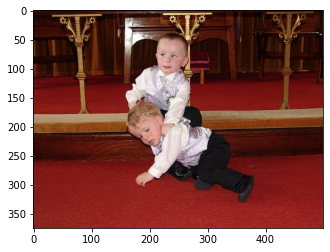

vgg19_LSTM_model_0.h5  girl in red shirt is playing in the air 
vgg19_LSTM_model_9.h5  girl in pink shirt and white shorts is dancing 
vgg19_LSTM_model_19.h5  girl in pink shirt is dancing in front of red house 
vgg19_LSTM_model_29.h5  girl in pink shirt is dancing 
vgg19_LSTM_model_39.h5  woman in pink shirt is sitting on the floor with her arms outstretched 
vgg19_LSTM_model_49.h5  woman in pink shirt is sitting on her lap in the midst of her team 


In [179]:
# set photo path - doing manually 
photo = filepath+'Flickr8k_Dataset/Flicker8k_Dataset/2638981862_6b23833f37.jpg'

# Display image
img = mpimg.imread(photo)
imgplot = plt.imshow(img)
plt.show()

# extact features using model
photo_features = extract_features(photo)


# load the model from path
model_names = ['vgg19_LSTM_model_0.h5','vgg19_LSTM_model_9.h5', 'vgg19_LSTM_model_19.h5',
               'vgg19_LSTM_model_29.h5','vgg19_LSTM_model_39.h5', 'vgg19_LSTM_model_49.h5']

# iterate over models which are every 10th model
for i in range(0,len(model_names)):
    
    # load specific model
    model = load_model(filepath+'vgg19_LSTM' + '/' + model_names[i])
    
    # generate description and add startseq and endseq
    description = generate_desc(model, tokenizer, photo_features, max_length)
    description = description.replace('startseq','').replace('endseq','')
    
    #print result
    print(model_names[i], description)

## Create histogram

In [ ]:
# function to plot histogram of vocabulary


def plot_histogram(dictionary_descriptions):

    # two emoty lists one to append captions to in group and another to each caption
    count_caption_length = []
    captions_list =  []

    # iterate over files
    for key in dictionary_descriptions:
        
        # iterate over captions as groups of 5
        for captions in dictionary_descriptions[key]: # list of lists
            
            # append lit of captions to list
            captions_list.append(captions)

    # for item in now populated list       
    for caption in captions_list:
        
        #spit each caption by white space to get count of word an append length to list
        count_caption_length.append(len(caption.split(" ")))

    # create figure
    plt.figure(figsize=(7, 7))
    
    # Count each unique occurances and puts in dictionary
    plt.bar(*zip(*Counter(count_caption_length).items()))
    
    # Set plot titles/heading
    plt.title('Histogram of tokenized captions by number of words ')# + str('Tokenized'))
    plt.ylabel('count')
    plt.xlabel('caption length')
    plt.show()

In [ ]:
plot_histogram(train_descriptions)

## Plot loss of inception resnet v3 models

Would like to plot all models but that would require rerunning for all those models and that would be inefficient

In [ ]:

# get file paths of the csv with the history of loss pe epoch
efficientnet_LSTM_df = pd.read_csv(filepath+'model_efficientnetv2s_LSTM_loss.csv')
efficientnet_GRU_df = pd.read_csv(filepath+'model_efficientnetv2s_GRU_loss.csv')

# select columns of interest after combining
combined = pd.concat([efficientnet_LSTM_df, efficientnet_GRU_df], axis=1)
combined = combined[['model_efficientnetv2s_LSTM_loss', 'model_efficientnetv2s_GRU_loss']]

In [ ]:
# plot from dataframe
combined.plot()
plt.title('Loss for EfficientNet v2 LSTM and GRU models ')# + str('Tokenized'))
plt.ylabel('loss ')
plt.xlabel('epoch')
plt.legend(['EfficientNet v2 s LSTM','EfficientNet v2 s GRU'],frameon=False)


## Additional info

During tinkering I have soemhow broken the incepion model and am unable to replicate getting the BLEU scores. I beleive its because I altered the input shape but I can't get it back into a working state even after reverting to a previously working notebook. I unfortunately do not have the time available to further investigate this issue.

VGG19 and efficientnet models run perfectly, other models have issues which are problematic to rectify even though they worked previously. 